In [116]:
import pandas as pd 

In [117]:
data = pd.read_csv('./fastfood.csv', na_values=['-', ' ', ''])

In [118]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   512 non-null    object 
 1   item         515 non-null    object 
 2   calories     515 non-null    int64  
 3   cal_fat      514 non-null    float64
 4   total_fat    515 non-null    int64  
 5   sat_fat      515 non-null    float64
 6   trans_fat    515 non-null    float64
 7   cholesterol  515 non-null    int64  
 8   sodium       515 non-null    int64  
 9   total_carb   515 non-null    int64  
 10  fiber        503 non-null    float64
 11  sugar        515 non-null    int64  
 12  protein      513 non-null    float64
 13  calcium      305 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 56.5+ KB


,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,calcium
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60.0,7,2.0,0.0,95,1110,44,3.0,11,37.0,20.0
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410.0,45,17.0,1.5,130,1580,62,2.0,18,46.0,20.0
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600.0,67,27.0,3.0,220,1920,63,3.0,18,70.0,50.0
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280.0,31,10.0,0.5,155,1940,62,2.0,18,55.0,20.0
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410.0,45,12.0,0.5,120,1980,81,4.0,18,46.0,20.0


In [119]:
data = data.loc[data['total_fat'] < 125]

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 514
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   510 non-null    object 
 1   item         513 non-null    object 
 2   calories     513 non-null    int64  
 3   cal_fat      512 non-null    float64
 4   total_fat    513 non-null    int64  
 5   sat_fat      513 non-null    float64
 6   trans_fat    513 non-null    float64
 7   cholesterol  513 non-null    int64  
 8   sodium       513 non-null    int64  
 9   total_carb   513 non-null    int64  
 10  fiber        501 non-null    float64
 11  sugar        513 non-null    int64  
 12  protein      511 non-null    float64
 13  calcium      304 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 60.1+ KB


In [121]:
data.drop(columns='calcium', inplace=True) # Izbacujemo celu kolonu jer ima previse nedostajucih vrednosti
data.drop(columns=['restaurant', 'item'], inplace=True) # Izbacujemo cele kolone jer nisu numerickog tipa, predstavljaju samo nazive restorana i hrane, nemaju veze sa predikcijom proteina

In [122]:
from scipy.stats import shapiro

na_features = ['cal_fat', 'fiber', 'protein']

for feature in na_features:
    subset = data[feature].dropna()
    _, p = shapiro(subset)
    print(f'{p:.5f}') # p < 0.05 => nije normalna, koristimo median
    if(p < 0.05):
        data[feature].fillna(data[feature].median(), inplace=True)


0.00000
0.00000
0.00000


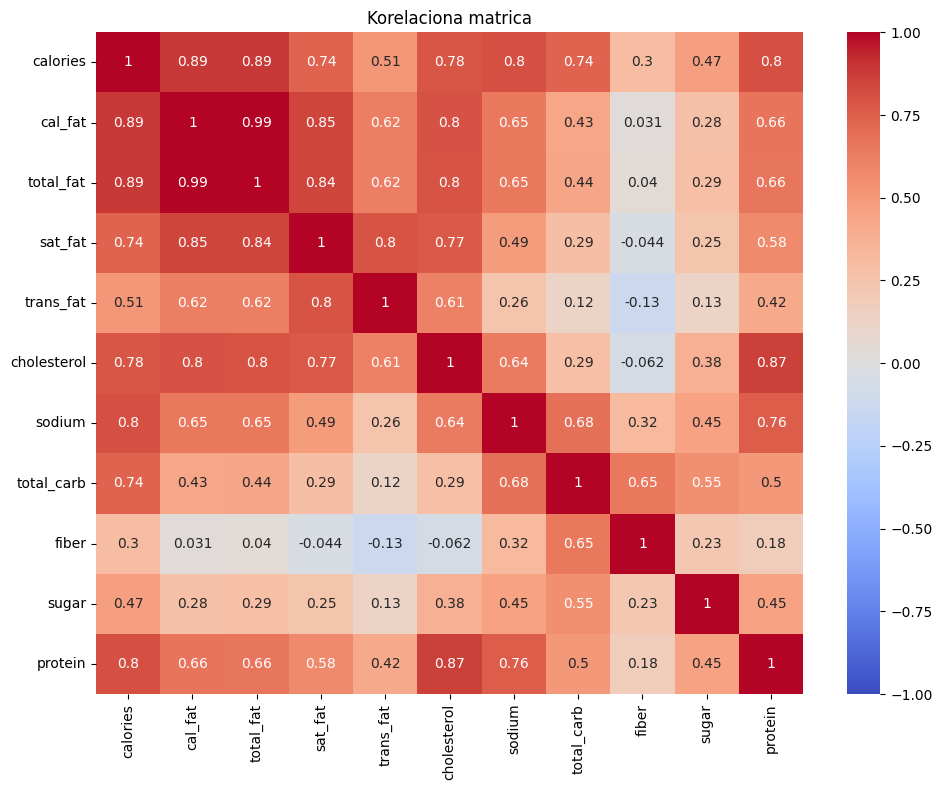

In [123]:
import matplotlib.pyplot as plt
import seaborn as sb
corr_matrix = data.corr(numeric_only=True).round(2)
plt.figure(figsize=(10, 8))
sb.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Korelaciona matrica")
plt.tight_layout()
plt.show()

In [124]:
# Postavicemo granicu na 0.7
# Korelaciona matrica nam govori koliko ce se promeniti kolicina proteina za promenu jedne jedinice drugog feature-a, npr ako povecamo kalorije za jednu jedinicu, protein ce se povecati za 0.81
data.drop(columns=['cal_fat', 'total_fat', 'sat_fat','trans_fat', 'total_carb', 'fiber', 'sugar'], inplace=True)

In [125]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)
train_features = train_data.drop(columns='protein')
model = smf.ols(formula='protein ~' + ' + '.join(train_features.columns), data=train_data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                protein   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     598.7
Date:                Mon, 08 Sep 2025   Prob (F-statistic):          1.25e-148
Time:                        11:09:58   Log-Likelihood:                -1374.2
No. Observations:                 410   AIC:                             2756.
Df Residuals:                     406   BIC:                             2773.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7467      0.774      3.551      

In [126]:
# Za svaku jedinicnu promenu calories ce povecati protein za 0.0053
# Za svaku jedinicnu promenu cholesterol ce povecati protein za 0.1823
# Za svaku jedinicnu promenu sodium ce povecati protein za 0.0072

# Reziduali oznacavaju razliku izmedju pravih i predvidjenih vrednosti, najbolje je da su ravnomerno rasporedjeni oko 0.

# Intercept znaci da kada su sve nezavisne varijable jednake 0, protein je jednak 2.8934

# Posto su svakoj nezavisnoj varijabli p vrednost manje od 0.05, sve su statisticki znacajne. Posebno cholesterol i sodium.

# R-squared = 0.824 => model objasnjava oko 0.824 ciljne promenljive.

# F-statistic = 792.3, Prob = mnogo mali broj => model kao celina je znacajan. 
# (F-statistic - podela vrednosti kad smo ubacili nase nezavisne varijable vs kad je samo intercept)
# (Prob = koliko je velika verovatnoca da bismo dobili ovako dobar model sa random nezavisnim varijablama)

# The condition number is large, 3.46e+03. This might indicate that there are strong multicollinearity or other numerical problems.
# Detaljnije cemo proveriti multikolinearnost pomocu VIF vrednosti

In [127]:
X_test = test_data.drop(columns='protein')
y_test = test_data['protein']
y_predicted = model.predict(X_test)

In [128]:
pd.DataFrame({
    'Stvarno': y_test,
    'Predvidjeno': y_predicted
})

,Stvarno,Predvidjeno
34,28.0,23.891304
202,22.0,21.010936
86,15.0,15.677141
276,13.0,18.341021
36,58.0,46.539851
...,...,...
152,30.0,28.801978
290,23.0,32.502777
43,49.0,45.882513
481,14.0,16.714769
